In [7]:
import state_space_sim
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jax
from tqdm import trange, tqdm
import sys


# set randomness
np.random.seed(42)
jax_key = jax.random.PRNGKey(42)

# Utility functions
This segment contains support functions for calculating EIS using discrete-random binary excitation signal.

In [8]:
def estimate_pdf(u_cof, i_cof):
    """
    Implementation of equation (7) in the paper https://doi.org/10.1016/j.jpowsour.2014.06.110
    """
    s11 = np.nanmean(np.multiply(u_cof,np.conj(u_cof)),axis=1)
    s12 = np.nanmean(np.multiply(i_cof,np.conj(u_cof)),axis=1)
    s21 = np.nanmean(np.multiply(u_cof,np.conj(i_cof)),axis=1)
    s22 = np.nanmean(np.multiply(i_cof,np.conj(i_cof)),axis=1)
    
    rho = np.divide(np.divide(s12,np.sqrt(s11)),np.sqrt(s22))
    s1 = np.sqrt(s11)
    s2 = np.sqrt(s22)
    z = np.divide(np.multiply(np.conj(rho),s1),s2)
    
    return rho, s1, s2,z



In [9]:
import numpy as np
def drbsgen(fs, fb, prbs_length):
    """
    DRBSGEN Random binary signal generator.
    
    DRBSGEN generates signal with:
    fs - sampling frequency
    fb - bandwith of the DRBS signal
    prbs_length - length of the signal in seconds
    seed - set seed for random number generator (in order to exactly recreate results) 
    """

    f_prbs = 3*fb;
    N = int(np.around(fs/f_prbs, decimals=0))
    Ns = int(np.ceil((prbs_length*fs)/N));
    lb = int(np.ceil(prbs_length*fs));
    prbs = np.ones(int(lb))#*np.nan;
    
    for idx in range(1,Ns):
        x = np.around(np.random.uniform(0,1),decimals=0);
        if(x==0):
            x = 0;
        prbs[((idx-1)*N+1):idx*N+1] = x;
   
    t = np.arange(0,len(prbs))/fs;
    t = t[0:lb];
    prbs = np.append(prbs[1:lb],prbs[-1]);
    return prbs,t





# Model parameteres
The z-domain model assumes RQ elements. Below $C$ is actually $Q$.

In [10]:

# U = jnp.array(oU)


Rs = jnp.array(3.)
R = jnp.array([1., 2., 3.])
C = jnp.array([.1, 1., 10.])
alfa = jnp.array([0.88, 0.82, 0.99])


In [11]:
def sim_z(Rs, R, C, alfa,fs, I):
    A, bl, m, d, T_end = state_space_sim.jgen(Rs,R,C,alfa,fs,len(I))
    mask = state_space_sim.generate_mask(A.shape)
    x_init = jnp.zeros(A.shape)
    return state_space_sim.forward_sim(A, bl, m, d, x_init, I, mask)

In [12]:
def add_white_noise(data, noise_level, key):
    return data + noise_level * jax.random.normal(key, data.shape)



## Simulation loop

<div class="alert alert-info">
The code below can be rather slow if you do not have GPU.
Start it and immediately check with nvidia-smi or nvtop if GPU is used.
</div>

In [24]:
excitation = []
response = []


# fb = [1000,100,10,1,0.1]#,0.01,0.005]
# length = [1,3,10,100,300,500,5000]
# fs = [50000,5000,1000,500,500,100,100]


apply_noise = True
noise_level = 0.05

fbs = np.array([1,10])#,10,100,1000])#1000,100,10,1,0.1])
durations = [10,5]#,10,3,1]#[1,3,10,100,300]#,500,5000]
fss = [10000,1000]#,1000,5000,50000]#[50000,5000,1000,500,500,]#100,100]

for i,fb in enumerate(tqdm(fbs)):
    prbs,t = drbsgen(fss[i], fb, durations[i])
    I = jnp.array(prbs)
    y = sim_z(Rs, R, C, alfa,  fss[i], I)
    if apply_noise:
            y = add_white_noise(y, noise_level, jax.random.fold_in(jax_key, 100))
    excitation.append(jnp.asarray(I, copy=True))
    response.append(jnp.asarray(y, copy=True))

100%|██████████| 2/2 [00:00<00:00, 188.44it/s]


### Print data

In [14]:
print(response)
print(excitation)
print(response[0].shape)

[Array([ 0.01185318, -0.02818577,  0.0101271 , ...,  4.192061  ,
        4.1651964 ,  4.0739737 ], dtype=float32), Array([3.0118532, 2.9982975, 3.0591884, ..., 4.415227 , 4.430772 ,
       4.308001 ], dtype=float32)]
[Array([0., 0., 0., ..., 1., 1., 1.], dtype=float32), Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)]
(100000,)


### Plot data

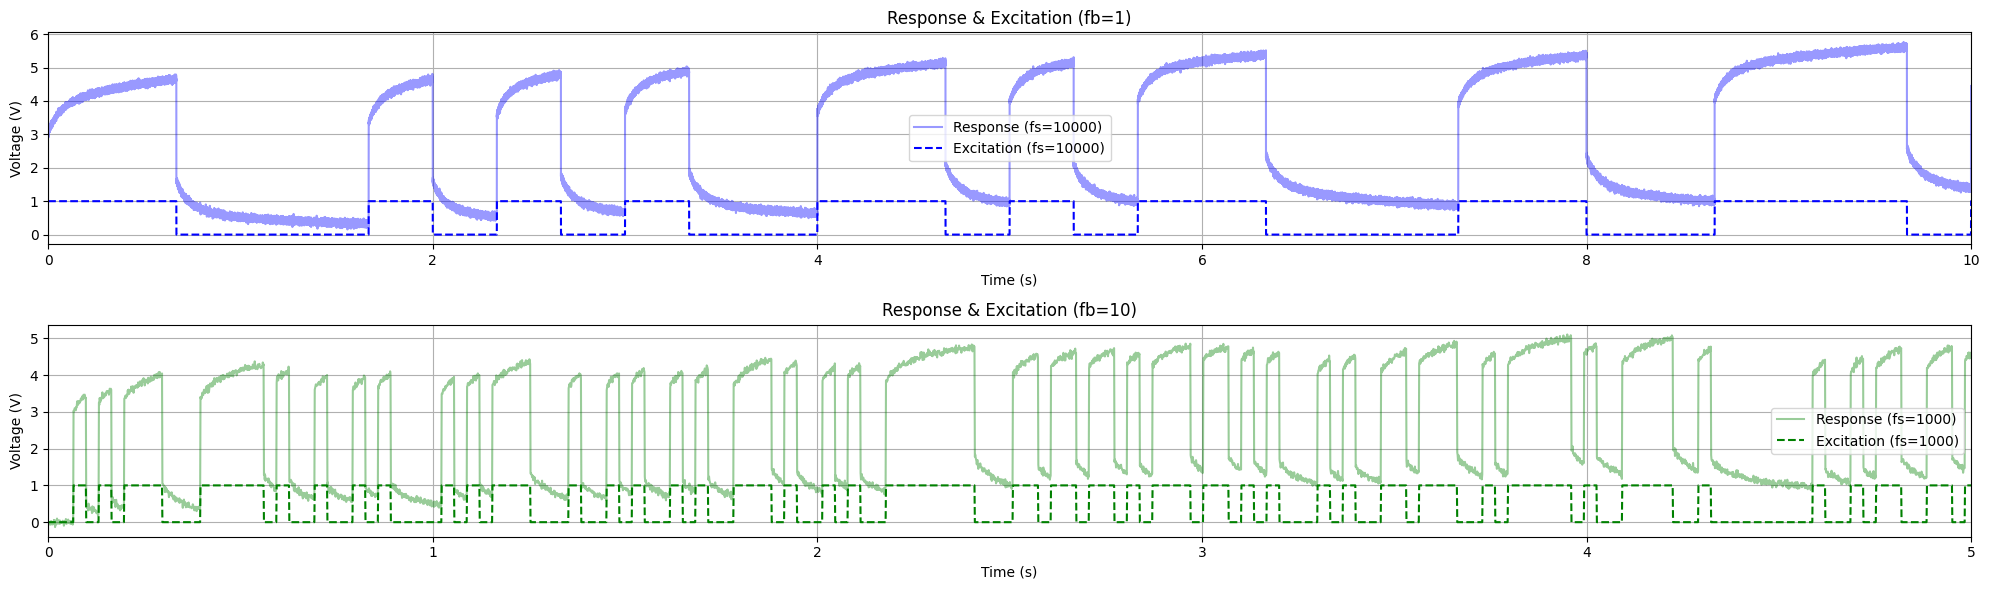

In [25]:
# Create subplots per frequency (fb)
fig, axs = plt.subplots(len(fbs), 1, figsize=(20, len(fbs) * 3))
colors = ['b', 'g', 'r', 'm']
linestyles = ['-', '--']

for i, (fb, fs, duration, resp, exc) in enumerate(zip(fbs, fss, durations, response, excitation)):
    time = np.linspace(0, duration, len(resp))
    
    # Plot response and excitation on the same subplot
    axs[i].plot(time, resp, color=colors[i], linestyle=linestyles[0], alpha=0.4, label=f'Response (fs={fs})')
    axs[i].plot(time, exc, color=colors[i], linestyle=linestyles[1],  label=f'Excitation (fs={fs})')
    axs[i].set_title(f'Response & Excitation (fb={fb})')
    axs[i].set_xlim([0, time[-1]])
    axs[i].legend()
    axs[i].grid(True)

    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Voltage (V)")

fig.tight_layout()
plt.show()

## Sin simulation
If you do not need sine signals, skip this cell.

If needed install package ```py_eis``` from [here](https://repo.ijs.si/pboskoski/py_eis.git) and add 
```
import py_eis.cwt_eis as cwt_eis
```



In [16]:
sin_freqs = np.array([.1,.5,.9,1,2,3,4,5,9,10,20,30,40,50,90,100,200,300,400,500,900,1000,5000])
s_exc = []
s_resp = []
s_fs = []
for freq in tqdm(sin_freqs):
    dur = 1/freq * 10
    fs = max(500,freq * 5)
    s_fs.append(fs)
    t = jnp.arange(0,dur,1/fs)
    I = jnp.sin(2*jnp.pi*freq*t)
    y = sim_z(Rs, R, C, alfa,  fs, I)
    s_exc.append(jnp.asarray(I, copy=True))
    s_resp.append(jnp.asarray(y, copy=True))
    # break

100%|██████████| 23/23 [00:12<00:00,  1.78it/s]


In [17]:
Z_sin = []
for cnt, freq in enumerate(sin_freqs):
    fs =  max(500,freq * 5)
    Z_sin.append( cwt_eis.impedance_sin(s_resp[cnt], s_exc[cnt], freq, fs) )

Z_sin = np.array(Z_sin)

## Calculation of CWT EIS
It uses ``jax`` implementation of CWT.
Ultra fast with GPU.

The file ``cwt_gpu.py`` is available [here](https://repo.ijs.si/pboskoski/eis_daq/-/blob/graz_working/cwt_gpu.py?ref_type=heads).

The parameter ```snr``` determines the desired singal-to-noise ratio of the measurement noise.

0.001
0.001 0.5 2
0.001 0.5 2
0.001 0.15
0.01
0.01 0.5 2
0.01 0.5 2
0.1
0.1 0.5 2
1.0
10.0
100.0
1000.0


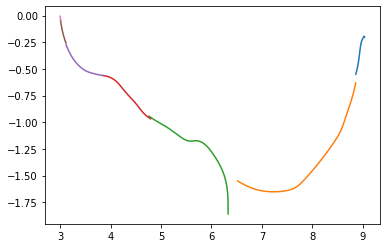

In [79]:
import cwt_gpu
Z_prbs = np.array([])
f_wt_site = np.array([])

key = jax.random.PRNGKey(datetime.datetime.now().microsecond)
key, *subkey = jax.random.split(key,len(fbs)+1)
snr = -13
for cnt, fb in enumerate(fbs):
    
    fs = fss[cnt]
    fmin = fbs[cnt]/10.
    fmax = fbs[cnt]
    

    i = excitation[cnt]

    i_power = jnp.mean(jnp.power(i,2))
    noise_pow = i_power * jnp.power(10,-snr/10)


    unoise = jax.random.normal(ikey, shape=i.shape)*jnp.power(noise_pow,.5)
    u = response[cnt]+ unoise
    
    wp = cwt_gpu.MorseWavelet(f0=0.5,a=3)
    print(fbs[cnt])
    if fbs[cnt] <= .1:
        wp = cwt_gpu.MorseWavelet(f0=0.5,a=2)
        print(fbs[cnt],0.5,2)
    
    if fbs[cnt] <= .01:
        wp = cwt_gpu.MorseWavelet(f0=0.5,a=2)
        print(fbs[cnt],0.5,2)
    
    if fbs[cnt] < .01:
        print(fbs[cnt],0.15)
        wp = cwt_gpu.MorseWavelet(f0=0.15,a=1)

    iwt_pad,freq_wt_pad = cwt_gpu.do_cwt(i, fs,wp,nv=20,fmin=fmin,fmax=fmax)
    uwt_pad,freq_wt_pad = cwt_gpu.do_cwt(u, fs,wp,nv=20,fmin=fmin,fmax=fmax)

    # wp = wt.MorseWavelet(f0=0.5,a=3) 
    # iwt_pad,freq_wt_pad = wt.wavelet_transform(i,fs,wp,fmin=fmin,fmax=fmax,padding=np.mean(i),cut_edges=False,nv=20)
    # uwt_pad,freq_wt_pad = wt.wavelet_transform(u,fs,wp,fmin=fmin,fmax=fmax,padding=np.mean(u),cut_edges=False,nv=20)

    
    uwt_pad = np.array(uwt_pad)
    iwt_pad = np.array(iwt_pad)
    freq_wt_pad = np.array(freq_wt_pad)

    new_rho, s1, s2,z_est = estimate_pdf(uwt_pad, iwt_pad)
    # print(z_est.shape)
    plt.plot(z_est.real, z_est.imag)
    f_wt_site=np.append(f_wt_site,freq_wt_pad)
    Z_prbs = np.append(Z_prbs,z_est)


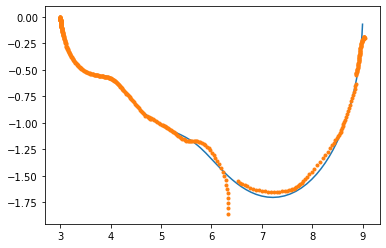

In [80]:
plt.plot(Z.real, Z.imag)
plt.plot(Z_prbs.real, Z_prbs.imag,'.')


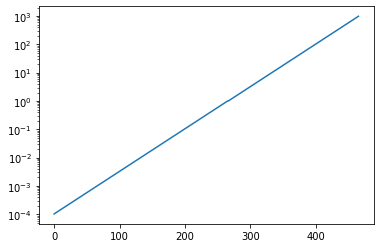

In [33]:
plt.semilogy(f_wt_site)

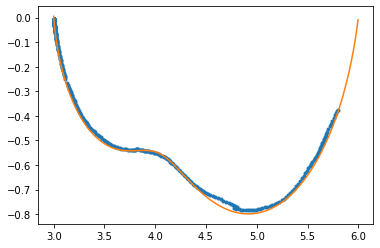

In [12]:
plt.plot(z_fode.real, z_fode.imag,'.')
plt.plot(Z.real, Z.imag)